In [132]:
import os
import sys
import random
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import tensorflow as tf
from nltk.tokenize import word_tokenize

In [133]:
sys.path.insert(0, os.path.join(os.getcwd(), "..", "src", "data"))
sys.path.insert(0, os.path.join(os.getcwd(), "..", "src", "utils"))
sys.path.insert(0, os.path.join(os.getcwd(), "..", "src", "models"))
sys.path.insert(0, os.path.join(os.getcwd(), "..", "src", "models", "evaluations"))

In [134]:
from DataLoader import DataLoader
from EvaluationContainer import EvaluationContainer

In [135]:
results_folder = "model_recommendations"
if not os.path.isdir(results_folder):
    os.makedirs(results_folder)

# Load test data

In [ ]:
d = DataLoader()
d_authors = DataLoader()

In [ ]:
query_test, truth = d.evaluation_data_with_abstracts_citations()
query_test_authors = d_authors.test_data_with_abstracts_citations().author_names().data[["author_name", "chapter"]]

### Sample test data (100 random samples)

In [ ]:
sample_size = 100

In [ ]:
sampled_indices = random.sample(range(len(query_test)), sample_size)

In [ ]:
sampled_queries = [query_test[i] for i in sampled_indices]
sampled_truth = [truth[0][i] for i in sampled_indices]

In [ ]:
sampled_chapters = [sampled_queries[i][0] for i in range(len(sampled_queries))]

In [ ]:
sampled_authors = query_test_authors[query_test_authors.chapter.isin(sampled_chapters)]

In [136]:
sampled_data_file = os.path.join(results_folder, "sampled_data")

In [ ]:
with open(sampled_data_file, "wb") as f:
    pickle.dump([sampled_indices, sampled_queries, sampled_truth, sampled_authors], f)

In [137]:
with open(sampled_data_file, "rb") as f:
    sampled_indices, sampled_queries, sampled_truth, sampled_authors = pickle.load(f)

# Compute, evaluate and save predictions

In [138]:
evaluator = EvaluationContainer()

### GraphSAGE_RL

In [ ]:
sys.path.insert(0, os.path.join(os.getcwd(), "..", "src", "models", "graphsage_rl"))
from GraphSAGERLModel import GraphSAGERLModel

In [ ]:
graphsagerl_model = GraphSAGERLModel(
                embedding_type="SUM_L",
                graph_type="citations_authors_het_edges",
                train_prefix="SUM_L/citations_authors_het_edges/train_val",
                model_name="mean_concat", nonlinear_sampler=True,
                fast_ver=True, allhop_rewards=True, model_size="small",
                learning_rate=0.001, epochs=10, dropout=0.0, weight_decay=0.0,
                max_degree=100, samples_1=25, samples_2=10, samples_3=0,
                dim_1=512, dim_2=512, dim_3=0, batch_size=128, sigmoid=False,
                identity_dim=0,
                base_log_dir='../../../data/processed/graphsage_rl/',
                validate_iter=5000, validate_batch_size=128, gpu=None,
                print_every=5, max_total_steps=10**10,
                log_device_placement=False, recs=10, threshold=2)

In [ ]:
graphsagerl_recommendations = graphsagerl_model.query_batch((sampled_queries, sampled_authors))

In [ ]:
len(graphsagerl_recommendations[0])

In [141]:
evaluator.evaluate(graphsagerl_recommendations, [sampled_truth])

Recall       = 0.470
Precision(1) = 0.047
Precision(0) = 0.047
MAP          = 0.224
MAP@1        = 0.150
MAP@3        = 0.185
MAP@5        = 0.201
MAP@10       = 0.224
0.47 0.04699999999999999 0.04699999999999999 0.22414285714285714 0.15 0.185 0.20149999999999998 0.22414285714285714


[0.47,
 0.04699999999999999,
 0.04699999999999999,
 0.22414285714285714,
 0.15,
 0.185,
 0.20149999999999998,
 0.22414285714285714]

In [139]:
graphsagerl_rec_file = os.path.join(results_folder, "graphsagerl_recommendations.pkl")

In [ ]:
with open(graphsagerl_rec_file, "wb") as f:
    pickle.dump(graphsagerl_recommendations, f)

In [140]:
with open(graphsagerl_rec_file, "rb") as f:
    graphsagerl_recommendations = pickle.load(f)

### GAT

In [10]:
sys.path.insert(0, os.path.join(os.getcwd(), "..", "src", "models", "gat"))
from GATModel import GATModel

In [ ]:
gat_model = GATModel(
                embedding_type="SUM_2L", dataset="citations_authors_het_edges",
                graph_type="directed", hid_units=[64], n_heads=[8, 1],
                learning_rate=0.005, weight_decay=0, epochs=100000,
                batch_size=1, patience=100, residual=True,
                nonlinearity=tf.nn.elu, sparse=True, ffd_drop=0.5,
                attn_drop=0.5, gpu=0, recs=10, threshold=2)

In [ ]:
gat_recommendations = gat_model.query_batch((sampled_queries, sampled_authors))

In [ ]:
len(gat_recommendations[0])

In [144]:
evaluator.evaluate(gat_recommendations, [sampled_truth])

Recall       = 0.540
Precision(1) = 0.054
Precision(0) = 0.054
MAP          = 0.275
MAP@1        = 0.180
MAP@3        = 0.235
MAP@5        = 0.255
MAP@10       = 0.275
0.54 0.053999999999999965 0.053999999999999965 0.2751309523809524 0.18 0.235 0.2545 0.2751309523809524


[0.54,
 0.053999999999999965,
 0.053999999999999965,
 0.2751309523809524,
 0.18,
 0.235,
 0.2545,
 0.2751309523809524]

In [142]:
gat_rec_file = os.path.join(results_folder, "gat_recommendations.pkl")

In [ ]:
with open(gat_rec_file, "wb") as f:
    pickle.dump(gat_recommendations, f)

In [143]:
with open(gat_rec_file, "rb") as f:
    gat_recommendations = pickle.load(f)

### HAN

In [ ]:
sys.path.insert(0, os.path.join(os.getcwd(), "..", "src", "models", "han"))
from HANModel import HANModel

In [ ]:
han_model = HANModel(
                model="HeteGAT_multi", embedding_type="AVG_L", hid_units=[128],
                n_heads=[8, 1], learning_rate=0.005, weight_decay=0,
                epochs=10000, batch_size=1, patience=100, residual=True,
                nonlinearity=tf.nn.elu, ffd_drop=0.5, attn_drop=0.5, gpu=0,
                recs=10)

In [ ]:
han_recommendations = han_model.query_batch((sampled_queries, sampled_authors))

In [ ]:
len(han_recommendations[0])

In [147]:
evaluator.evaluate(han_recommendations, [sampled_truth])

Recall       = 0.500
Precision(1) = 0.050
Precision(0) = 0.050
MAP          = 0.239
MAP@1        = 0.140
MAP@3        = 0.200
MAP@5        = 0.222
MAP@10       = 0.239
0.5 0.04999999999999998 0.04999999999999998 0.2393809523809524 0.14 0.19999999999999996 0.22249999999999992 0.2393809523809524


[0.5,
 0.04999999999999998,
 0.04999999999999998,
 0.2393809523809524,
 0.14,
 0.19999999999999996,
 0.22249999999999992,
 0.2393809523809524]

In [145]:
han_rec_file = os.path.join(results_folder, "han_recommendations.pkl")

In [ ]:
with open(han_rec_file, "wb") as f:
    pickle.dump(han_recommendations, f)

In [146]:
with open(han_rec_file, "rb") as f:
    han_recommendations = pickle.load(f)

### SciBERT + ARGA

In [11]:
sys.path.insert(0, os.path.join(os.getcwd(), "..", "src", "models", "scibert_arga"))
from SciBERT_ARGAModel import SciBERT_ARGAModel

In [12]:
scibert_arga_model = SciBERT_ARGAModel(
                embedding_type="AVG_L", dataset="citations_authors_het_edges", arga_model_name="ARGA",
                graph_type="directed", n_latent=16, learning_rate=0.001,
                weight_decay=0, dropout=0, dis_loss_para=1, reg_loss_para=1,
                epochs=200, gpu=None, ffnn_hidden_dim=500, recs=10)

INFO:transformers.file_utils:TensorFlow version 2.0.0 available.
INFO:transformers.file_utils:PyTorch version 1.3.0 available.
INFO:transformers.modeling_xlnet:Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
INFO:transformers.tokenization_utils:Model name '/work/aiana/graph_confrec/src/data/../../data/external/scibert_scivocab_uncased/vocab.txt' not found in model shortcut name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese, bert-base-german-cased, bert-large-uncased-whole-word-masking, bert-large-cased-whole-word-masking, bert-large-uncased-whole-word-masking-finetuned-squad, bert-large-cased-whole-word-masking-finetuned-squad, bert-base-cased-finetuned-mrpc, bert-base-german-dbmdz-cased, bert-base-german-dbmdz-uncased). Assuming '/work/aiana/graph_confrec/src/data/../../data/external/scibert_scivocab_uncased/vocab.txt' is a path o

Initializing pretrained SciBERT model.


INFO:transformers.tokenization_utils:Model name '/work/aiana/graph_confrec/src/data/../../data/external/scibert_scivocab_uncased/vocab.txt' not found in model shortcut name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese, bert-base-german-cased, bert-large-uncased-whole-word-masking, bert-large-cased-whole-word-masking, bert-large-uncased-whole-word-masking-finetuned-squad, bert-large-cased-whole-word-masking-finetuned-squad, bert-base-cased-finetuned-mrpc, bert-base-german-dbmdz-cased, bert-base-german-dbmdz-uncased). Assuming '/work/aiana/graph_confrec/src/data/../../data/external/scibert_scivocab_uncased/vocab.txt' is a path or url to a directory containing tokenizer files.
INFO:transformers.tokenization_utils:Didn't find file /work/aiana/graph_confrec/src/data/../../data/external/scibert_scivocab_uncased/added_tokens.json. We won't load it.
INFO:transformers.tokenization_

SciBERT model initialized.
Initializing pretrained SciBERT model.
SciBERT model initialized.
Model: ARGA
	Embedding: AVG_L, Dataset: citations_authors_het_edges, Graph type: directed
	Hidden units: 16
	Learning rate: 0.001
	Weight decay: 0
	Dropout: 0

	Epochs: 200

Loading training data...
Process 'chapters_year' not in memory yet.
Process 'chapters_books' not in memory yet.
Process 'chapters_title' not in memory yet.
Process 'chapters_language' not in memory yet.
Process 'books_conferences' not in memory yet.
Process 'conferences_acronym' not in memory yet.
Process 'conferences_city' not in memory yet.
Process 'conferences_country' not in memory yet.
Process 'conferences_datestart' not in memory yet.
Process 'conferences_dateend' not in memory yet.
Process 'conferences_name' not in memory yet.
Process 'conferences_year' not in memory yet.
Process 'conferences_conferenceseries' not in memory yet.
Process 'conferenceseries_name' not in memory yet.
Process 'chapters_abstract' not in mem

In [13]:
scibert_arga_recommendations = scibert_arga_model.query_batch((sampled_queries, sampled_authors))

Process 'chapters_year' not in memory yet.
Process 'chapters_books' not in memory yet.
Process 'chapters_title' not in memory yet.
Process 'chapters_language' not in memory yet.
Process 'books_conferences' not in memory yet.
Process 'conferences_acronym' not in memory yet.
Process 'conferences_city' not in memory yet.
Process 'conferences_country' not in memory yet.
Process 'conferences_datestart' not in memory yet.
Process 'conferences_dateend' not in memory yet.
Process 'conferences_name' not in memory yet.
Process 'conferences_year' not in memory yet.
Process 'conferences_conferenceseries' not in memory yet.
Process 'conferenceseries_name' not in memory yet.
Process 'chapters_abstract' not in memory yet.
Process 'chapters_confproc_scigraph_citations' not in memory yet.
Process 'chapters_books' not in memory yet.
Process 'chapters_title' not in memory yet.
Process 'chapters_language' not in memory yet.
Process 'chapters_year' not in memory yet.
Process 'books_conferences' not in memo

Adding citation neighbours:   0%|          | 0/100 [00:00<?, ?it/s]

Preprocessing data...
Updating graph information...


Creating features:   0%|          | 0/100 [00:00<?, ?it/s]

Updated.
Creating features for test data...


Creating features: 100%|██████████| 100/100 [01:45<00:00,  1.10s/it]


Created.
Finished preprocessing data.
Splitting edges...


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

Finished splitting edges.
Loading model...
Loaded.

Computing embeddings...


Computing SciBERT embeddings:   0%|          | 0/100 [00:00<?, ?it/s]

Computed.



Computing SciBERT embeddings: 100%|██████████| 100/100 [01:19<00:00,  1.14it/s]


Computed.
Loading model...
Loaded.

Computing predictions...
Computed.


In [14]:
len(scibert_arga_recommendations[0])

100

In [150]:
evaluator.evaluate(scibert_arga_recommendations, [sampled_truth])

Recall       = 0.500
Precision(1) = 0.050
Precision(0) = 0.050
MAP          = 0.242
MAP@1        = 0.140
MAP@3        = 0.207
MAP@5        = 0.224
MAP@10       = 0.242
0.5 0.04999999999999998 0.04999999999999998 0.24160317460317463 0.14 0.20666666666666667 0.22416666666666668 0.24160317460317463


[0.5,
 0.04999999999999998,
 0.04999999999999998,
 0.24160317460317463,
 0.14,
 0.20666666666666667,
 0.22416666666666668,
 0.24160317460317463]

In [148]:
scibert_arga_rec_file = os.path.join(results_folder, "scibert_arga_recommendations.pkl")

In [17]:
with open(scibert_arga_rec_file, "wb") as f:
    pickle.dump(scibert_arga_recommendations, f)

In [149]:
with open(scibert_arga_rec_file, "rb") as f:
    scibert_arga_recommendations = pickle.load(f)

# Process recommendations

In [151]:
d = DataLoader()
data = d.training_data_with_abstracts_citations().data

Process 'chapters_year' not in memory yet.
Process 'chapters_books' not in memory yet.
Process 'chapters_title' not in memory yet.
Process 'chapters_language' not in memory yet.
Process 'books_conferences' not in memory yet.
Process 'conferences_acronym' not in memory yet.
Process 'conferences_city' not in memory yet.
Process 'conferences_country' not in memory yet.
Process 'conferences_datestart' not in memory yet.
Process 'conferences_dateend' not in memory yet.
Process 'conferences_name' not in memory yet.
Process 'conferences_year' not in memory yet.
Process 'conferences_conferenceseries' not in memory yet.
Process 'conferenceseries_name' not in memory yet.
Process 'chapters_abstract' not in memory yet.
Process 'chapters_confproc_scigraph_citations' not in memory yet.


In [152]:
def get_series_name(data, recommendation):
    conferenceseries = list()
    for conf in recommendation:
        conferenceseries.append(
                data[data.conferenceseries == conf].iloc[0]["conferenceseries_name"])
    return conferenceseries

In [153]:
graphsagerl_conferences = list()
for i in range(len(graphsagerl_recommendations[0])):
    rec = graphsagerl_recommendations[0][i]
    graphsagerl_conferences.extend(get_series_name(data, rec))
len(graphsagerl_conferences)

1000

In [154]:
gat_conferences = list()
for i in range(len(gat_recommendations[0])):
    rec = gat_recommendations[0][i]
    gat_conferences.extend(get_series_name(data, rec))
len(gat_conferences)

1000

In [155]:
han_conferences = list()
for i in range(len(han_recommendations[0])):
    rec = han_recommendations[0][i]
    han_conferences.extend(get_series_name(data, rec))
len(han_conferences)

1000

In [156]:
scibert_arga_conferences = list()
for i in range(len(scibert_arga_recommendations[0])):
    rec = scibert_arga_recommendations[0][i]
    scibert_arga_conferences.extend(get_series_name(data, rec))
len(scibert_arga_conferences)

1000

# Compute similarities

In [157]:
def jaccard_similarity(list1, list2): 
    tokenized_list1 = list()
    tokenized_list2 = list()
    for string in list1:
        tokenized_list1.extend(word_tokenize(string))
    for string in list2:
        tokenized_list2.extend(word_tokenize(string))
    set1 = set(tokenized_list1) 
    set2 = set(tokenized_list2)
    return len(set1.intersection(set2)) / len(set1.union(set2))

In [158]:
recommendations = {"graphsagerl": graphsagerl_conferences, "gat": gat_conferences, 
                   "han": han_conferences, "scibert_arga": scibert_arga_conferences}

In [160]:
sim_df = pd.DataFrame(np.ones((len(recommendations.keys()), len(recommendations.keys()))), 
                      index=list(recommendations.keys()), columns=list(recommendations.keys()))
sim_df

,graphsagerl,gat,han,scibert_arga
graphsagerl,1.0,1.0,1.0,1.0
gat,1.0,1.0,1.0,1.0
han,1.0,1.0,1.0,1.0
scibert_arga,1.0,1.0,1.0,1.0


In [161]:
for models in itertools.combinations(recommendations.keys(), 2):
    sim_df.loc[models] = sim_df.loc[tuple(reversed(models))] = jaccard_similarity(recommendations[models[0]],
                                                                                 recommendations[models[1]])

In [162]:
sim_df

,graphsagerl,gat,han,scibert_arga
graphsagerl,1.000000,0.790840,0.742029,0.719764
gat,0.790840,1.000000,0.785088,0.792738
han,0.742029,0.785088,1.000000,0.767103
scibert_arga,0.719764,0.792738,0.767103,1.000000


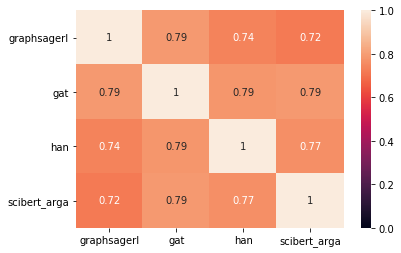

In [166]:
sns.heatmap(sim_df, annot=True, vmin=0, vmax=1)